# The Data

The work performed herein was built off of the shoulders of giants, the original project that created the dataset and labeled the images. Here follows an excerpt from their site describing the data.

> [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4002935.svg)](https://doi.org/10.5281/zenodo.4002935)
>__Project member(s)__:\
>Topher Allen; Zach Anderson; Berlin Chen; Ameya Daigavane; Annie Didier; Marko Green; Paul Horton; Hannah Kerner; Lauren Klein; Benjamin Kolber; Ellie Kuang; Kyle Kung; Jake Lee; Justin Martia; Brian Milch; James Montgomery; Kyle Pearson; Sanjna Ravichandar; Arun Viswanathan; Caleb Wagner; Amruta Yelamanchili; Brandon Zhao
>
>__Abstract__:\
>This dataset contains a total of 64,947 landmark images that were detected and extracted from HiRISE browse images, spanning 232 separate source images.
>
>This set was formed from 10,815 original landmarks. Each original landmark was cropped to a square bounding box that included the full extent of the landmark plus a 30-pixel margin to the left, right, top, and bottom. Each landmark was then resized to 227x227 pixels. 9,022 of these images were then augmented to generate 6 additional landmarks using the following methods:
>
>90 degrees clockwise rotation
>180 degrees clockwise rotation
>270 degrees clockwise rotation
>Horizontal flip
>Vertical flip
>Random brightness adjustment
>The remaining 1,793 images were not augmented. Combining these with the 7*9,022 images, gives a total of 64,947 separate images.
>
> __Contents__:
>- map-proj-v3_2/: Directory containing individual cropped landmark images
>- labels-map-proj-v3_2.txt: Class labels (ids) for each landmark image. File includes two columns separated by a space: filename, class_id
>- labels-map-proj-v3_2_train_val_test.txt: Includes train/test/val labels and upsampling used for trained model. File includes three columns separated by a space: filename, class_id, set
>- landmarks_map-proj-v3_2_classmap.csv: Dictionary that maps class ids to semantic names
>
> __Class Discussion__:\
>We give a discussion of the various landmarks that make up our classes.
>
>Bright dune and dark dune are two sand dune classes found on Mars. Dark dunes are completely defrosted, whereas bright dunes are not. Bright dunes are generally bright due to overlying frost and can exhibit black spots where parts of the dune are defrosting.
>
>The crater class consists of crater images in which the diameter of the crater is greater than or equal to 1/5 the width of the image and the circular rim is visible for at least half the crater's circumference.
>
>The slope streak class consists of images of dark flow-like features on slopes. These features are believed to be formed by a dry process in which overlying (bright) dust slides down a slope and reveals a darker sub-surface.
>
>Impact ejecta refers to material that is blasted out from the impact of a meteorite or the eruption of a volcano. We also include cases in which the impact cleared away overlying dust, exposing the underlying surface. In some cases, the associated crater may be too small to see. Impact ejecta can also include lava that spilled out from the impact (blobby ("lobate") instead of blast-like), more like an eruption (triggered by the impact). Impact ejecta can be isolated, or they can form in clusters when the impactor breaks up into multiple fragments.
>
>Spiders and Swiss cheese are phenomena that occur in the south polar region of Mars. Spiders have a central pit with radial troughs, and they are believed to form as a result of sublimation of carbon dioxide ice. This process can produce mineral deposits on top, which look like dark or light dust that highlights cracks in the CO2 ice. Spiders can resemble impact ejecta due to their radial troughs, but impact ejecta tends to have straight radial jets that fade as they get farther from the center. The spider class also includes fan-like features that form when a geyser erupts through the CO2 layer and the material is blown by the wind away from the cracks. Fans are typically unidirectional (following the wind direction), whereas impact ejecta often extends in multiple directions. Swiss cheese is a terrain type that consists of pits that are formed when the sun heats the ice making it sublimate (change solid to gas).
>
>Other is a catch-all class that contains images that fit none of the defined classes of interest. This class makes up the majority of our data set.


# Business Understanding

Space exploration and understanding has been growing over the last few decades with the spark being lit during the space race during the latter half of the 20th century. After the end of the Apollo space program, man's venture into space has been relegated to low earth orbit missions.  

Unmanned missions have since had many a success story such as the Voyager 2 going interstellar in 2018, over 40 years after its launch. The future of space exploration is going to be handled by such manned missions for the foreseeable future. However, being physically on site isn't the only way to explore space.  

For centuries, man has looked up at the night sky to find out more about our celestial neighbors. With improvements in technologies our ability to gather data through telescopes and cameras has improved significantly and the value provided by telescopes in space has been immeasurable. The James Webb (infrared) telescope was launched in December 2021 and hopes to view objects too old, distant, and faint for the Hubble Space Telescope.

Pointing the telescope and gathering data is only the first step. Being able to parse terabytes, petabytes or even yottabytes of data manually is a nigh impossible task, a task computer vision is especially suited for. Being able to identify interesting features can help us whittle down potential candidates to explore 'in-person' and in the long run help mitigate losses.

Interest in space exploration has seen a resurgence with private enterprise taking an interest. Although this project specifically looks at the Mars topography, similar techniques can be applied to any celestial body, or even to our home planet.

# Overview
We shall be using images captured from the HiRISE camera system on board the Mars Reconnaisance Orbiter which was built under direction from University of Arizona's Lunar and Planetary Laboratory. Following is an excerpt from the [University of Arizona website](https://www.lpl.arizona.edu/missions/hirise-mro).

>The __Hi__gh __R__esolution __I__maging __S__cience __E__xperiment (HiRISE) onboard the Mars Reconnaissance Orbiter, is the most powerful camera ever sent to another planet. The resolution of the camera allows us to see the Red Planet in amazing detail, and lets other missions, like the Mars Science Laboratory, find a safe place to land and carry out amazing science. The operations center, which includes not only observation planning, but the execution of commands sent to the spacecraft along with actual image processing, is located within LPL at the University of Arizona.

We shall be building off of the work performed by the original team. The dataset comes pre-augmented and segmented into training, validation and test sets. The test side will be set aside to ascertain effectiveness of our final model. The training set will be used to train the model and the validation scores on the validation set will be used as a metric to pick our model, specifically our validation loss.

# Imports

In [1]:
from PIL import Image, ImageDraw
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

In [2]:
from src.imageHandler import *

# Final Model Selection
To recap, we trained a variety of different models using Adam as an optimizer function. After looking at our modeling efforts across 4 notebooks, [02_TensorflowModeling_FinalModels](./02_TensorflowModeling_FinalModels.ipynb), [03_TensorflowModeling_AlexNet](./03_TensorflowModeling_AlexNet.ipynb), [04_TensorflowModeling_LeNet](./04_TensorflowModeling_LeNet.ipynb), [05_TensorflowModeling_VGG16_TransferLearning](./05_TensorflowModeling_VGG16_TransferLearning.ipynb), the VGG16 transfer training model is the clear winner.

In [3]:
final_model = tf.keras.models.load_model('tf_TransferLearning_8class_VGG16.hfpy')

In [4]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


In [5]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


In [6]:
final_model.evaluate(val_generator);

14175/14175 [==============================] - 118s 8ms/step - loss: 0.3356 - accuracy: 0.9073


In [7]:
final_model.evaluate(test_generator);

1793/1793 [==============================] - 14s 8ms/step - loss: 0.3541 - accuracy: 0.9230


Our chosen model performed with an accuracy of about **90.73%** on the validation set and **92.3%** on the holdout (test set) with a corresponding loss of about **0.3356** and **0.3541** respectively. This clearly outperforms are baseline Dummy Classifier

We shall now utilize this model to make anomaly predictions on the Martian surface

In [8]:
im1 = Image.open('mass_maps/AEB_000002_0000_RED.NOMAP.browse.jpg')
im1

Next we'll create a data frame of all bounding boxes for a given image. 
A potential bounding box in this case is a slice of the image that could potentially hold a feature. The following function essentially returns a series of coordinates of slices of varying size encompassing the entire image. 

3 different window sizes were chosen. 75%, 100%, 150% of the base window size. In this case the base window size was set to size of the images in the dataset *277px*. A certain amount of overlap is allowed between slices in order to ensure features were not accidentally missed. This is currently set at *40%*

In [10]:
# Read a dataframe from a precreated csv. If the appropriate csv doesn't exist
# Create one in './mass_maps/'
df_bbox = getPotentialBboxes(im1)
df_bbox

reading current


,bbox_bounds,winsize
0,"(0, 0, 208, 208)",208
1,"(0, 125, 208, 333)",208
2,"(0, 250, 208, 458)",208
3,"(0, 375, 208, 583)",208
4,"(0, 500, 208, 708)",208
...,...,...
1626,"(1500, 6250, 1916, 6666)",416
1627,"(1500, 6500, 1916, 6916)",416
1628,"(1500, 6750, 1916, 7166)",416
1629,"(1500, 7000, 1916, 7416)",416


In [11]:
# Using the above data frame crop slices of the larger image
# Create a folder to hold slices in './mass_maps/'
list_imagesToClassify = [im1.crop(df_bbox.iloc[rowNum]['bbox_bounds'])
                         for rowNum in range(0,df_bbox.shape[0])]
saveImageSlices(list_imagesToClassify,im1.filename)

In [12]:
# Normalizing data for 8 bit
predict_datagen = ImageDataGenerator(rescale=1./255)

print('./mass_maps/_slices_img/')
predict_generator = predict_datagen.flow_from_directory(
    'mass_maps/',
    target_size = (227,227),
    batch_size=8,
    color_mode='rgb',
    class_mode=None
)
predict_generator.reset()

preds = final_model.predict(predict_generator)

./mass_maps/_slices_img/
Found 1631 images belonging to 1 classes.
204/204 [==============================] - 8s 35ms/step


# Predicting on Slices

Now that we have created each potential slice of the image that could potentially hold a feature belonging to one of our classes, we can now use our model to predict on each of these images. First we will need to create a prediction generator

In [13]:
# Normalizing data for 8 bit
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_generator = predict_datagen.flow_from_directory(
    'mass_maps/',
    target_size = (227,227),
    batch_size=100,
    color_mode='rgb',
    class_mode=None
)
predict_generator.reset()



Found 1631 images belonging to 1 classes.


With our model and images loaded all we have to do is use the predict method to get a list of predictions for each of our image slices.

In [14]:
preds = final_model.predict(predict_generator)

17/17 [==============================] - 12s 395ms/step


Lets have a look at the first image and its associated prediction

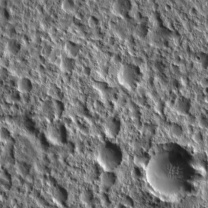

In [15]:
list_imagesToClassify[0]

In [16]:
[round(x,3) for x in preds[0]]

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

Each prediction is an array of probabilities of the likelihood that an image belongs to a particular class. In the above case, the model is 99.9% confident that the first slice belongs to class *4*. Looking at the class indices from our test set, we can see that this means the model thinks the image belongs to the `other` class.

In [17]:
test_generator.class_indices

{'bright dune': 0,
 'crater': 1,
 'dark dune': 2,
 'impact ejecta': 3,
 'other': 4,
 'slope streak': 5,
 'spider': 6,
 'swiss cheese': 7}

Knowing this we can now predict the class for each image. We will do so using the following function.
*-1* as a `predClass1` is reserved to indicate that no class feature was able to cross the confidence threshold.

In [18]:
classDict = {
    -1: '-',
    0: 'bright dune',
    1:  'crater',
    2:  'dark dune',
    3:  'impact ejecta',
    4:  'other',
    5:  'slope streak',
    6:  'spider',
    7:  'swiss cheese'}

In [19]:
confidence_threshold = 0.9
df_bbox['predClass'] = [getClassFromPred(pred,confidence_threshold) for pred in preds]
df_bbox['predClassName'] = df_bbox['predClass'].map(classDict)
df_bbox

,bbox_bounds,winsize,predClass,predClassName
0,"(0, 0, 208, 208)",208,4,other
1,"(0, 125, 208, 333)",208,4,other
2,"(0, 250, 208, 458)",208,4,other
3,"(0, 375, 208, 583)",208,-1,-
4,"(0, 500, 208, 708)",208,4,other
...,...,...,...,...
1626,"(1500, 6250, 1916, 6666)",416,4,other
1627,"(1500, 6500, 1916, 6916)",416,4,other
1628,"(1500, 6750, 1916, 7166)",416,4,other
1629,"(1500, 7000, 1916, 7416)",416,4,other


# Annotating Original Image

Now that we have a list of all predicted classes, if we wanted to annotate the `crater` class onto the original image we can do so as follows. We will first have to subset the data frame by our class

In [20]:
df_crater = df_bbox[df_bbox.predClassName == 'crater']
df_crater

,bbox_bounds,winsize,predClass,predClassName
6,"(0, 750, 208, 958)",208,1,crater
24,"(0, 3000, 208, 3208)",208,1,crater
30,"(0, 3750, 208, 3958)",208,1,crater
36,"(0, 4500, 208, 4708)",208,1,crater
53,"(0, 6625, 208, 6833)",208,1,crater
72,"(125, 1375, 333, 1583)",208,1,crater
83,"(125, 2750, 333, 2958)",208,1,crater
96,"(125, 4375, 333, 4583)",208,1,crater
97,"(125, 4500, 333, 4708)",208,1,crater
127,"(250, 625, 458, 833)",208,1,crater


In [21]:
# Creating a color map
colorMap = {0: '#0796FF',
            1: '#FF00F4',
            2: '#FF9700',
            3: '#8DFF00',
            4: '#F277FD',
            5: '#FF008B',
            6: '#00475C',
            7: '#000000'}

In [ ]:
mask_img = Image.new("RGBA", (img_width, img_height), (0, 0, 0, 0))

for idx in range(0, df_crater.shape[0]):  
    drawBoundingRectangle(df_crater.iloc[idx]['bbox_bounds'],
                          mask_img,
                          color=colorMap[df_crater.iloc[idx]['predClass']]
                                         )

im2 = im1.convert('RGB')
im2.paste(mask_img,(0,0),mask_img)
im2

# Performance

Although my approach to bounding features may be a little rudimentary. A lot of the overlapping bounding boxes can be cleaned up with some advanced such as *Intersection Over Union*. However, there is currently a bigger  issue with the model. Lets look at the distribution of the positive predictions.

In [24]:
df_bbox.predClassName.value_counts(normalize=True)

other     0.890865
-         0.076027
crater    0.033109
Name: predClassName, dtype: float64

This shows that the model is still overwhelmingly predicting the `other` class. In fact, looking at this distribution, if we were to annotate the image with our `other` class, it'll be covered with annotations. Lets have a quick look.

In [ ]:
df_other = df_bbox[df_bbox.predClassName == 'other']

mask_img = Image.new("RGBA", (img_width, img_height), (0, 0, 0, 0))

for idx in range(0, df_other.shape[0]):  
    drawBoundingRectangle(df_other.iloc[idx]['bbox_bounds'],
                          mask_img,
                          color=colorMap[df_other.iloc[idx]['predClass']]
                                         )

im2 = im1.convert('RGB')
im2.paste(mask_img,(0,0),mask_img)
im2

Remember that each one of these patches had to overcome a confidence threshold of 90%! It seems that the massive imbalance in conjunction with the confounding nature of a "catch-all" class severely hampers the predictive capabilities of the model.

Even though my model performed with an accuracy of 92% on the test set, lets have a more detailed breakdown of the classification.

In [26]:
test_actual = test_generator.classes
test_preds_proba = final_model.predict_generator(test_generator,steps = 1793)
test_preds = [pred.argmax() for pred in  test_preds_proba]

C:\Users\saads\AppData\Local\Temp\ipykernel_31808\3196756981.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds_proba = final_model.predict_generator(test_generator,steps = 1793)


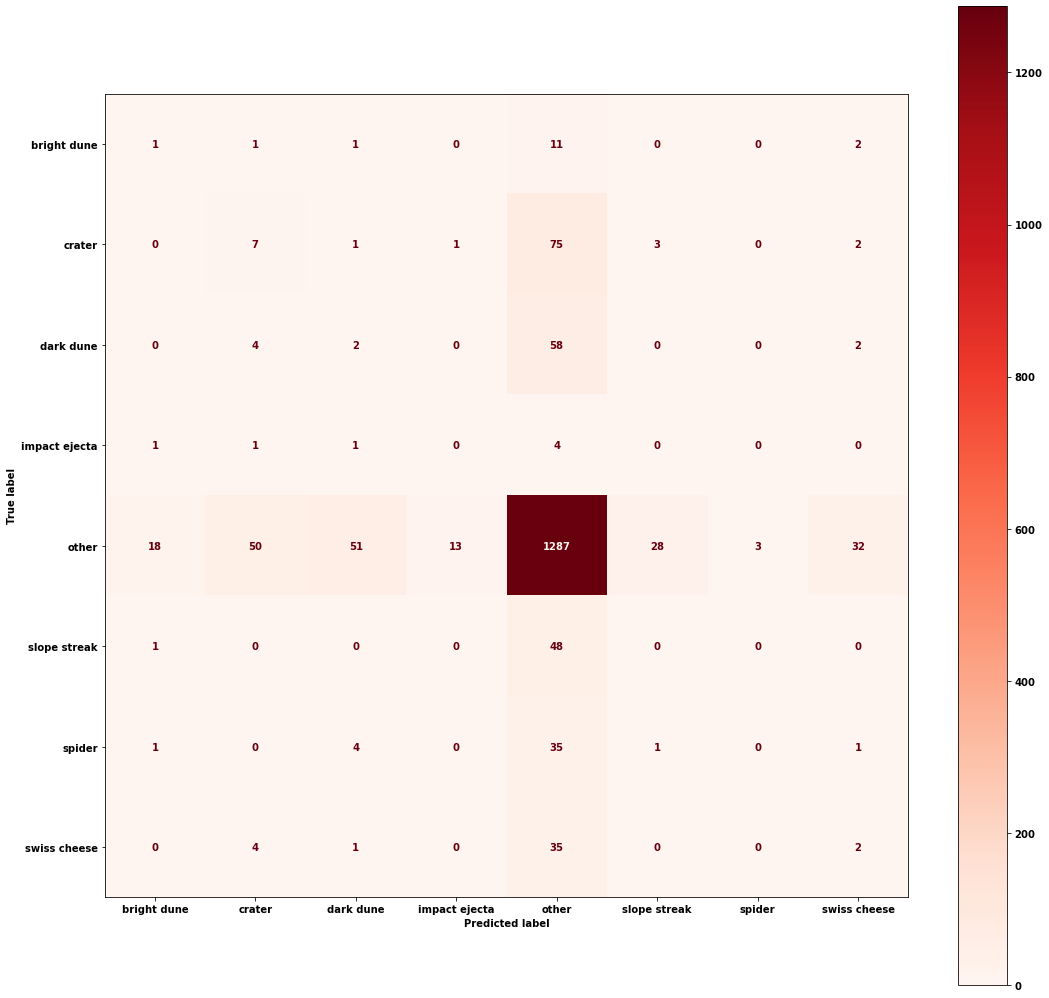

In [27]:
fig, ax = plt.subplots(figsize=(18,18))
disp = ConfusionMatrixDisplay(confusion_matrix(test_actual, test_preds),
                              display_labels=test_generator.class_indices
                             )

disp.plot(ax=ax,cmap='Reds');

In [28]:
print(classification_report(test_actual, test_preds))

              precision    recall  f1-score   support

           0       0.05      0.06      0.05        16
           1       0.10      0.08      0.09        89
           2       0.03      0.03      0.03        66
           3       0.00      0.00      0.00         7
           4       0.83      0.87      0.85      1482
           5       0.00      0.00      0.00        49
           6       0.00      0.00      0.00        42
           7       0.05      0.05      0.05        42

    accuracy                           0.72      1793
   macro avg       0.13      0.14      0.13      1793
weighted avg       0.69      0.72      0.71      1793



In [29]:
final_model.metrics_names

['loss', 'accuracy']

In [30]:
(test_preds == test_actual).sum()/1793

0.724484104852203

In [31]:
test = tf.nn.softmax(test_preds_proba)[0]

In [32]:
test

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.1031023 , 0.10380733, 0.10324699, 0.10325362, 0.27712777,
       0.10324559, 0.1031105 , 0.10310586], dtype=float32)>

In [33]:
test_preds_proba[0]

array([7.0359856e-06, 6.8219085e-03, 1.4093542e-03, 1.4736383e-03,
       9.8876405e-01, 1.3959494e-03, 8.6563377e-05, 4.1544296e-05],
      dtype=float32)

In [34]:
np.argmax(test_preds_proba[0])

4

In [35]:
test_actual

array([0, 0, 0, ..., 7, 7, 7])

# Conclusion
The final chosen model was the VGG16 pretrained model which was run through 500 more iterations to fine tune the weights for my particular problem set. 
Although the metrics of the final model is quantitatively satisfactory, its performance on true unseen data was poor. The imbalance in the dataset aside, the class of `others` was essentially a catch all for images that couldn't be classified into the other categories and/or human labelers had a hard time classifying in general. 

Even to the human eye these might look like they belong to the same set of features but they do not. The images belong to the classes `crater`, `impact ejecta` and `other` respectively.

![img](./savedFigs/eg_crater.jpg) 
![img](./savedFigs/eg_impactejecta.jpg) 
![img](./savedFigs/eg_other.jpg) 

One potential way of solving this issue would be to get even more data, but more importantly labeled data. This is especially true for the underepresented features like `spider`s and `impact ejecta`s. Completely reassessing how to classify these images might also help.

# Next Steps:

- Retrain AlexNet and LeNet with a smaller learning rate for a high number of iterations to see if they perform any better
- Use pretrained weights for AlexNet and LeNet to see if it performs any better
- Use a different metric to train against
- Undersample or completely drop the majority class `other` and see if resulting models are better at delineating features.
- Gather more labeled data
- Implement *Intersection Over Union* to clean up annotation of images